# Linear Algebra Project

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
pip install scikit-learn --upgrade

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 23.2 MB 142 kB/s eta 0:00:01     |██████████████████▋             | 13.5 MB 2.1 MB/s eta 0:00:05
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import math as math
from scipy.spatial import distance

import seaborn as sns
try:
    import sidetable
except:
    ! pip install sidetable -Uq
    import sidetable
    
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle


from sklearn.model_selection import train_test_split

from IPython.display import display

In [3]:
# ignore warnings
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [4]:
try:
    df = pd.read_csv('/datasets/insurance_us.csv')
except:
    df = pd.read_csv('insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [5]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [6]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
2852,0,34.0,35100.0,0,0
1551,1,42.0,40500.0,0,1
3472,0,22.0,16700.0,0,0
2864,1,37.0,45100.0,2,0
2096,0,23.0,40500.0,3,0
722,0,25.0,40200.0,1,0
1759,0,35.0,35100.0,2,0
1686,1,20.0,31600.0,2,0
2249,1,19.0,30000.0,1,0
548,1,33.0,41500.0,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null float64
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [8]:
# we may want to fix the age type (from float to int) though this is not critical
df['age'] = df.age.astype(int)

In [9]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null int64
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [10]:
# now have a look at the data's descriptive statistics. 
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Gender splits almost evenly between the values 1 and 0. Age is ranging from 18 YO to 65 with mean and median equal both to ~30. Income has the biggest scale with range from 5,300 to 79,000 with STD of 9900!. family members range from 1 to 6 with half of the population have 1 or less. The target insurance_benefits distributes from 0 to 5 where the majority have no benefits at all. 

In [11]:
print(df.duplicated().sum())

153


In [12]:
df[df.duplicated()]

,gender,age,income,family_members,insurance_benefits
281,1,39,48100.0,1,0
488,1,24,32900.0,1,0
513,0,31,37400.0,2,0
718,1,22,32600.0,1,0
785,0,20,35800.0,0,0
...,...,...,...,...,...
4793,1,24,37800.0,0,0
4902,1,35,38700.0,1,0
4935,1,19,32700.0,0,0
4945,1,21,45800.0,0,0


There are 152 duplicated rows which are not neccesserily duplicate since there is no unique identifoer to the row or customer. In addition this amount isn't big so it's better to leave them as is.

In [13]:
df.stb.missing(style=True)

,missing,total,percent
gender,0,"5,000",0.00%
age,0,"5,000",0.00%
income,0,"5,000",0.00%
family_members,0,"5,000",0.00%
insurance_benefits,0,"5,000",0.00%


 No missing values. yay :)

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

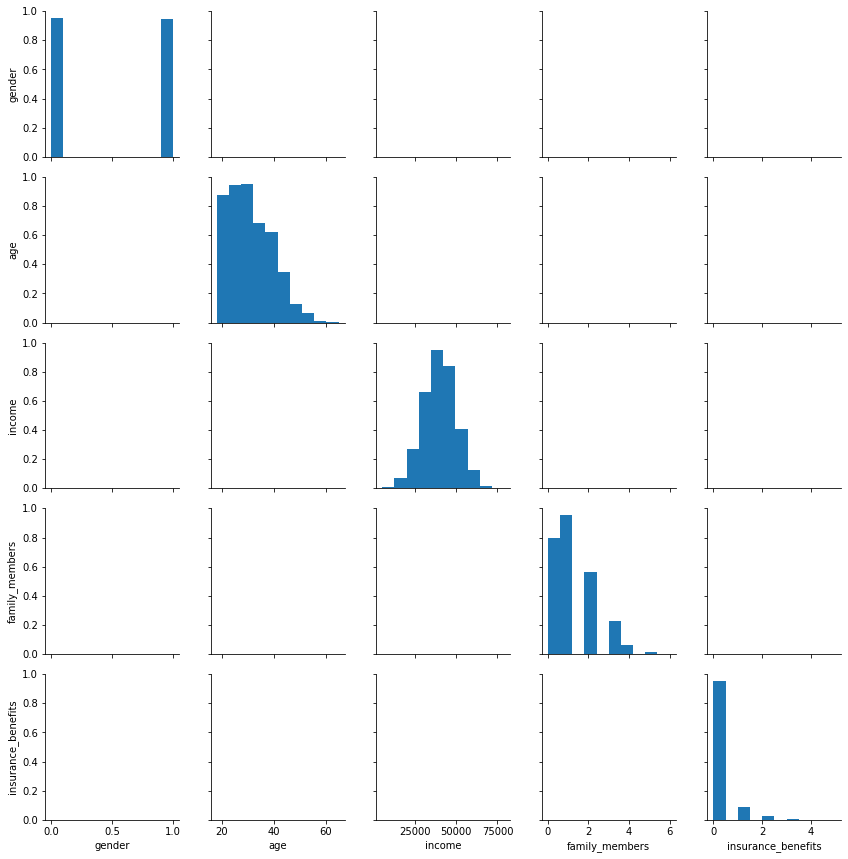

In [14]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [16]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [17]:
res = get_knn(df,6,5,'euclidean')

In [18]:
print(res)

      gender  age   income  family_members  insurance_benefits  distance
6          1   39  39700.0               2                   0  0.000000
4248       1   38  39700.0               1                   0  1.414214
3695       1   40  39700.0               3                   0  1.414214
1704       0   39  39700.0               0                   0  2.236068
4977       1   41  39700.0               0                   0  2.828427


Scaling the data.

In [19]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [20]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1335,1.0,0.353846,0.597468,0.000000,0
3138,0.0,0.538462,0.426582,0.333333,0
242,0.0,0.415385,0.465823,0.333333,0
70,1.0,0.646154,0.426582,0.166667,1
4704,0.0,0.676923,0.436709,0.166667,1


Now, let's get similar records for a given one for every combination

In [21]:
#combination: euclidean distance no scaling
print(get_knn(df,6,10,'euclidean'))

      gender  age   income  family_members  insurance_benefits  distance
6          1   39  39700.0               2                   0  0.000000
3695       1   40  39700.0               3                   0  1.414214
4248       1   38  39700.0               1                   0  1.414214
1704       0   39  39700.0               0                   0  2.236068
4977       1   41  39700.0               0                   0  2.828427
1253       1   34  39700.0               2                   0  5.000000
4362       1   45  39700.0               2                   1  6.000000
413        1   45  39700.0               0                   1  6.324555
350        0   33  39700.0               0                   0  6.403124
410        0   32  39700.0               1                   0  7.141428


In [22]:
#combination: euclidean distance with scaling
print(get_knn(df_scaled,6,10,'euclidean'))

      gender       age    income  family_members  insurance_benefits  distance
6        1.0  0.600000  0.502532        0.333333                   0  0.000000
1415     1.0  0.600000  0.505063        0.333333                   0  0.002532
108      1.0  0.600000  0.507595        0.333333                   0  0.005063
3713     1.0  0.600000  0.517722        0.333333                   0  0.015190
2997     1.0  0.584615  0.503797        0.333333                   0  0.015437
4434     1.0  0.600000  0.478481        0.333333                   0  0.024051
951      1.0  0.600000  0.474684        0.333333                   0  0.027848
4680     1.0  0.615385  0.478481        0.333333                   0  0.028550
3706     1.0  0.584615  0.477215        0.333333                   0  0.029624
77       1.0  0.615385  0.475949        0.333333                   0  0.030713


In [23]:
#combination: manhattan distance no scaling
print(get_knn(df,6,10,'manhattan'))

      gender  age   income  family_members  insurance_benefits  distance
6          1   39  39700.0               2                   0       0.0
3695       1   40  39700.0               3                   0       2.0
4248       1   38  39700.0               1                   0       2.0
1704       0   39  39700.0               0                   0       3.0
4977       1   41  39700.0               0                   0       4.0
1253       1   34  39700.0               2                   0       5.0
4362       1   45  39700.0               2                   1       6.0
413        1   45  39700.0               0                   1       8.0
410        0   32  39700.0               1                   0       9.0
350        0   33  39700.0               0                   0       9.0


In [24]:
#combination: manhattan distance with scaling
print(get_knn(df_scaled,6,10,'manhattan'))

      gender       age    income  family_members  insurance_benefits  distance
6        1.0  0.600000  0.502532        0.333333                   0  0.000000
1415     1.0  0.600000  0.505063        0.333333                   0  0.002532
108      1.0  0.600000  0.507595        0.333333                   0  0.005063
3713     1.0  0.600000  0.517722        0.333333                   0  0.015190
2997     1.0  0.584615  0.503797        0.333333                   0  0.016650
4434     1.0  0.600000  0.478481        0.333333                   0  0.024051
951      1.0  0.600000  0.474684        0.333333                   0  0.027848
4680     1.0  0.615385  0.478481        0.333333                   0  0.039435
3706     1.0  0.584615  0.477215        0.333333                   0  0.040701
77       1.0  0.615385  0.475949        0.333333                   0  0.041967


Let's try with a different record:  117

In [25]:
#combination: euclidean distance no scaling
print(get_knn(df,117,10,'euclidean'))

      gender  age   income  family_members  insurance_benefits   distance
117        1   52  32000.0               0                   2   0.000000
1315       0   48  32000.0               1                   1   4.242641
4925       1   44  32000.0               1                   1   8.062258
3914       1   39  32000.0               1                   0  13.038405
3813       1   36  32000.0               2                   0  16.124515
3828       0   32  32000.0               0                   0  20.024984
1687       0   32  32000.0               2                   0  20.124612
3910       0   30  32000.0               0                   0  22.022716
2173       1   29  32000.0               4                   0  23.345235
1434       0   26  32000.0               2                   0  26.095977


In [26]:
#combination: euclidean distance with scaling
print(get_knn(df_scaled,117,10,'euclidean'))

      gender       age    income  family_members  insurance_benefits  distance
117      1.0  0.800000  0.405063             0.0                   2  0.000000
95       1.0  0.800000  0.393671             0.0                   2  0.011392
4838     1.0  0.784615  0.375949             0.0                   2  0.032929
1692     1.0  0.784615  0.443038             0.0                   2  0.040973
339      1.0  0.830769  0.448101             0.0                   2  0.052906
859      1.0  0.753846  0.474684             0.0                   2  0.083529
4970     1.0  0.769231  0.484810             0.0                   2  0.085477
4632     1.0  0.830769  0.489873             0.0                   2  0.090219
1222     1.0  0.707692  0.408861             0.0                   1  0.092386
2052     1.0  0.753846  0.500000             0.0                   2  0.105561


In [27]:
#combination: manhattan distance no scaling
print(get_knn(df,117,10,'manhattan'))

      gender  age   income  family_members  insurance_benefits  distance
117        1   52  32000.0               0                   2       0.0
1315       0   48  32000.0               1                   1       6.0
4925       1   44  32000.0               1                   1       9.0
3914       1   39  32000.0               1                   0      14.0
3813       1   36  32000.0               2                   0      18.0
3828       0   32  32000.0               0                   0      21.0
1687       0   32  32000.0               2                   0      23.0
3910       0   30  32000.0               0                   0      23.0
2173       1   29  32000.0               4                   0      27.0
113        0   25  32000.0               0                   0      28.0


In [28]:
#combination: manhattan distance with scaling
print(get_knn(df_scaled,117,10,'manhattan'))

      gender       age    income  family_members  insurance_benefits  distance
117      1.0  0.800000  0.405063             0.0                   2  0.000000
95       1.0  0.800000  0.393671             0.0                   2  0.011392
4838     1.0  0.784615  0.375949             0.0                   2  0.044499
1692     1.0  0.784615  0.443038             0.0                   2  0.053359
339      1.0  0.830769  0.448101             0.0                   2  0.073807
1222     1.0  0.707692  0.408861             0.0                   1  0.096105
1568     1.0  0.907692  0.406329             0.0                   4  0.108958
4970     1.0  0.769231  0.484810             0.0                   2  0.110516
4632     1.0  0.830769  0.489873             0.0                   2  0.115579
859      1.0  0.753846  0.474684             0.0                   2  0.115774


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

The scaling improves the model a great deal. No matter the distance matric, the scaling returns a different set of neighbors. Without acaling the income feature is a great influencer on the neighbors picking. After the scaling other features are more similiar to each other like family status, age and gender. It happens because the scale of the sincome is very big compared to other features and hence it affects badly in the model cuase flatuations in income create a big distance between two observations. After scaling other features can have greater weights, more balanced between all features, in choosing neighbors in a way that describes the reality better. 

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The results of different distance metrics are not that different. Only when choosing a big amount of k neighbors, like 10, we can see a liitle different results berween the 2 metrics. Nevertheless after scaling those differences are not seen.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [29]:
# calculate the target

df['insurance_benefits_received'] = np.where(df['insurance_benefits']>0, 1, 0)


In [30]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts(normalize=True)

0    0.8872
1    0.1128
Name: insurance_benefits_received, dtype: float64

In [31]:
ratio = round(0.8872 / 0.1128)
print(ratio)

8


The target classes are very imbalanced. 88.7% of the customers don't have any insurance benefits. We'de better use some balancing tools to help our model become more accurtae and not neglecting the minority class - 1. Let's apply upsampling on the data.

In [32]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

In [33]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [34]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [35]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



The random model generated a very low F1 score of 0.0 with probability 0 since in this case the recall and percision are equal to 0 since there are no True Positives at all. The higher the P the more 1s are predicted and hence the F1 score is bigger. 

In [36]:
#split the data to train:test 70:30
train, test = train_test_split(df, test_size=0.3, random_state=12345)

In [37]:
train_features = train.drop(['insurance_benefits_received','insurance_benefits'], axis=1)
train_target = train['insurance_benefits_received']
test_features = test.drop(['insurance_benefits_received','insurance_benefits'], axis=1)
test_target = test['insurance_benefits_received']

In [38]:
#upsampling to balance the data
train_features, train_target = upsample(train_features, train_target, ratio)
test_features, test_target = upsample(test_features, test_target, ratio)

In [39]:
for k in range(1,11):
    for metric in ['manhattan','euclidean']:
        print('\n k: {}, distance: {} \n'.format(k,metric))
        model = KNeighborsClassifier(n_neighbors=k, metric=metric)
        model.fit(train_features, train_target)
        train_predict = model.predict(train_features)
        
        test_predict = model.predict(test_features)
        print("K Neighbors F1 Score on Test Set:")
        eval_classifier(test_target, test_predict)


 k: 1, distance: manhattan 

K Neighbors F1 Score on Test Set:
F1: 0.70
Confusion Matrix
[[0.49450966 0.01173798]
 [0.22415752 0.26959485]]

 k: 1, distance: euclidean 

K Neighbors F1 Score on Test Set:
F1: 0.68
Confusion Matrix
[[0.49450966 0.01173798]
 [0.23324498 0.26050738]]

 k: 2, distance: manhattan 

K Neighbors F1 Score on Test Set:
F1: 0.69
Confusion Matrix
[[0.4948883  0.01135933]
 [0.22718667 0.26656569]]

 k: 2, distance: euclidean 

K Neighbors F1 Score on Test Set:
F1: 0.67
Confusion Matrix
[[0.49450966 0.01173798]
 [0.23627414 0.25747823]]

 k: 3, distance: manhattan 

K Neighbors F1 Score on Test Set:
F1: 0.72
Confusion Matrix
[[0.47860659 0.02764105]
 [0.19992427 0.2938281 ]]

 k: 3, distance: euclidean 

K Neighbors F1 Score on Test Set:
F1: 0.72
Confusion Matrix
[[0.48049981 0.02574782]
 [0.20295343 0.29079894]]

 k: 4, distance: manhattan 

K Neighbors F1 Score on Test Set:
F1: 0.72
Confusion Matrix
[[0.47898523 0.0272624 ]
 [0.19992427 0.2938281 ]]

 k: 4, dista

The best F1 score is 0.74 for the following combinations:
k: 5, distance: euclidean 
k: 6, distance: euclidean 
k: 7, distance: euclidean 
k: 8, distance: euclidean 

It means that euclidean distance measure performs better in KNN model than manhattan and the optimal number of neighbors are 5-8. I guess that less neighbors are prowned to anomalies and hence less precise and big amount of neighbors  have some extra instances thatare not similiar enough to the predicted instance and affect badly on the model.


Let's scale the data and run the KNN model again

In [40]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(train_features.to_numpy())

train_features_scaled = train_features.copy()
train_features_scaled = transformer_mas.transform(train_features.to_numpy())

test_features_scaled = test_features.copy()
test_features_scaled = transformer_mas.transform(test_features.to_numpy())

In [41]:
for k in range(1,11):
    for metric in ['manhattan','euclidean']:
        print('\n k: {}, distance: {} \n'.format(k,metric))
        model = KNeighborsClassifier(n_neighbors=k, metric=metric)
        model.fit(train_features_scaled, train_target)
        
        test_predict = model.predict(test_features_scaled)
        test_score = eval_classifier(test_target, test_predict)


 k: 1, distance: manhattan 

F1: 0.98
Confusion Matrix
[[0.50473306 0.00151458]
 [0.02120409 0.47254828]]

 k: 1, distance: euclidean 

F1: 0.98
Confusion Matrix
[[0.50473306 0.00151458]
 [0.02120409 0.47254828]]

 k: 2, distance: manhattan 

F1: 0.98
Confusion Matrix
[[0.50473306 0.00151458]
 [0.02120409 0.47254828]]

 k: 2, distance: euclidean 

F1: 0.98
Confusion Matrix
[[0.50473306 0.00151458]
 [0.02120409 0.47254828]]

 k: 3, distance: manhattan 

F1: 0.99
Confusion Matrix
[[0.50056797 0.00567967]
 [0.00605831 0.48769406]]

 k: 3, distance: euclidean 

F1: 0.98
Confusion Matrix
[[0.49981068 0.00643696]
 [0.01514578 0.47860659]]

 k: 4, distance: manhattan 

F1: 0.99
Confusion Matrix
[[0.50056797 0.00567967]
 [0.00605831 0.48769406]]

 k: 4, distance: euclidean 

F1: 0.98
Confusion Matrix
[[0.49981068 0.00643696]
 [0.01514578 0.47860659]]

 k: 5, distance: manhattan 

F1: 0.99
Confusion Matrix
[[0.49526694 0.01098069]
 [0.00302916 0.49072321]]

 k: 5, distance: euclidean 

F1: 0.9

The F1 score is much higher after the scailing. It went up to 0.98 and 0.99. It's very high!
The best combinations here are:
k: 8, distance: manhattan 
k: 7, distance: manhattan 
k: 6, distance: manhattan 
k: 5, distance: manhattan 
k: 4, distance: manhattan 
k: 3, distance: manhattan 

It seems that after the scaling the better distance matric is manhattan

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [42]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y
#         self.weights = weights[1:]
#         self.w0 = weights[0]

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [43]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [44]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [45]:
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(X_train)

# x_train_scaled = X_train.copy()
x_train_scaled = transformer_mas.transform(X_train)

# x_test_scaled = x_test.copy()
x_test_scaled = transformer_mas.transform(X_test)

In [46]:
lr.fit(x_train_scaled, y_train)
print(lr.weights)

y_test_pred = lr.predict(x_test_scaled)
eval_regressor(y_test, y_test_pred)

[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


The RMSE and F1 evaluations metrics haven't changed at all after scaling using the MaxAbsScaler.
It seems that linear regression modle isn't sensitive to scaling like KNN for example. The reason is that unlike distance-based models, in linear regression there are weights, that can counteract the difference of scales. Scaling can still be useful if we want to interpret the weights, or if we use L1 or L2 regularization, which use distances

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Mupliplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [47]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [48]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [49]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [50]:
p_invers = np.linalg.inv(P)
print(p_invers)

[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


Can you guess the customers' ages or income after the transformation?

In [51]:
x_obfus = X.dot(P)
print(x_obfus)

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


The obfuscation changes the matrix a lot. The scale of the values is much higher

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

yes we can multiply by the invers of P

In [52]:
original_x = x_obfus.dot(p_invers)
print(original_x)

[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [ 1.67952800e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-6.23021448e-13  2.90000000e+01  2.10000000e+04 -2.03032656e-13]
 ...
 [ 1.57996161e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04  3.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  4.06000000e+04  1.00000000e+00]]


It looks similiar but not exactly the same. Let's compare

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [53]:
print('The original data:')
print(X[40:50])
print('The transformed one:')
print(x_obfus[40:50])
print('The reversed (recovered) one:')
print(original_x[40:50])

The original data:
[[1.00e+00 4.20e+01 4.02e+04 0.00e+00]
 [1.00e+00 3.90e+01 3.17e+04 1.00e+00]
 [1.00e+00 4.20e+01 6.92e+04 0.00e+00]
 [0.00e+00 2.00e+01 3.31e+04 1.00e+00]
 [0.00e+00 3.00e+01 3.16e+04 2.00e+00]
 [0.00e+00 2.40e+01 3.04e+04 1.00e+00]
 [0.00e+00 2.60e+01 3.45e+04 1.00e+00]
 [0.00e+00 4.20e+01 3.87e+04 1.00e+00]
 [1.00e+00 2.50e+01 3.31e+04 1.00e+00]
 [0.00e+00 2.80e+01 3.66e+04 1.00e+00]]
The transformed one:
[[ 5154.89743822 18146.92972061 14938.90703955 37289.66462056]
 [ 4066.29289355 14316.54514306 11785.28382867 29410.03126116]
 [ 8870.19278581 31208.12191958 25692.0497423  64165.84929717]
 [ 4243.08865364 14928.10975299 12289.08081034 30691.86965572]
 [ 4052.50384322 14263.10983128 11740.93858521 29309.81005422]
 [ 3897.55855481 13715.97021008 11290.97070372 28192.74844305]
 [ 4423.01280347 15564.50380015 12812.76488247 31994.05702594]
 [ 4962.59689827 17471.73469694 14382.29481948 35899.04700798]
 [ 4244.33349643 14933.42674319 12293.74510677 30696.49734527]
 [

Let's convert to int to see how really differnret the valsues are from each other

In [54]:
print('The original data:')
print(X[40:50].astype(int))
print('The reversed (recovered) one:')
print(original_x[40:50].astype(int))

The original data:
[[    1    42 40200     0]
 [    1    39 31700     1]
 [    1    42 69200     0]
 [    0    20 33100     1]
 [    0    30 31600     2]
 [    0    24 30400     1]
 [    0    26 34500     1]
 [    0    42 38700     1]
 [    1    25 33100     1]
 [    0    28 36600     1]]
The reversed (recovered) one:
[[    1    41 40200     0]
 [    0    38 31700     1]
 [    1    41 69200     0]
 [    0    20 33100     1]
 [    0    30 31600     1]
 [    0    24 30399     0]
 [    0    26 34500     0]
 [    0    42 38700     1]
 [    1    25 33099     0]
 [    0    28 36599     1]]


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

Answer: The memory of the computer is limited and hence the computer rounds the outcome of each procedure and chnage it a little bit. limitations of floating point arithmetic

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

#### How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

$Pw_P = w$

or

$w_P = [P]^{-1} w$

when applying P transformation on $w_P$ we get w.

Alternatively when applying $[P]^{-1}$ transformation on w we get $w_P$

**Analytical proof**

$ w = (X^T X)^{-1} X^T y $  
$ y = X w $

$$ w_P = [(XP)^T XP]^{-1} (XP)^T y $$
apply $(AB)^{-1} = B^{-1}A^{-1}$
$$ \Rightarrow w_P = [P^T X^T XP]^{-1} P^T X^T y $$
apply Associative property of multiplication
$$ \Rightarrow w_P = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y $$
apply $A^{-1}A = AA^{-1} = I$
$$ \Rightarrow w_P = P^{-1} (X^T X)^{-1} I X^T y $$
apply Multiplicative identity property
$$ \Rightarrow w_P = P^{-1} (X^T X)^{-1} X^T y $$
substitute $(X^T X)^{-1} X^T y $ with $w$
$$ \Rightarrow w_P = P^{-1} w $$
Q.E.D

#### What would be predicted values with $w_P$? 
$$ {y_{p}} = XP w_{p}$$
substitute $w_p$ with the link we recieved $w_P = P^{-1} w $
$$ \Rightarrow {y_{p}} = XP P^{-1} w $$
apply $A^{-1}A = AA^{-1} = I$
$$ \Rightarrow {y_{p}} = X I_{n} w $$
apply Multiplicative identity property
$$ \Rightarrow {y_{p}} = X w $$
applying our base equation $ y = X w $
$$ \Rightarrow {y_{p}} = y $$

Q.E.D

The predictions $y$ and $y_p$ are the same 

#### What does that mean for the quality of linear regression if you measure it with RMSE?

Since we prooved that the predfictions are identical before and after obfuscation the RMSE would be the same, since RMSE only looks at the final prediction versus the target that stayed as is (and n doesn't change as well).

$$  RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big({target_i -prediction_i}\Big)^2}} $$

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Use a class that runs Linear Regression and run it on X
- Use $XP$ as the new feature matrix

In [55]:
# Generating a random matrix P
rng = np.random.default_rng(seed=12345)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [56]:
# Checking the matrix $P$ is invertible
p_invers = np.linalg.inv(P)
print(p_invers)

[[-1.97240014  1.76004024 -0.08309671  1.22285233]
 [ 0.14111106  0.32873452  1.02824721 -1.27752175]
 [ 0.8908452   0.90302415 -0.59501472 -0.23290483]
 [ 1.02530945 -1.81039816  0.24787878  0.46192295]]


luckily we found an inversible matrix. Yay!

In [57]:
# Use a class that runs Linear Regression and run it on X
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [58]:
# Use $XP$ as the new feature matrix
XP_train = X_train.dot(P)
XP_test = X_test.dot(P)

lr.fit(XP_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(XP_test)
eval_regressor(y_test, y_test_pred)

[-0.94353857 -0.05589528  0.02537907  0.04940432  0.00151456]
RMSE: 0.34
R2: 0.66


We can clearly see that the scores haven't changed at all. It make sense because we prooved that the predictions are the same.

# Conclusions

 First we uden a KNN model and test it for four combination of two cases:
with / without scaling
and
 Euclidean/Manhattan distance metric
We found out that the scaling improves the model a great deal.since it’s balancing the weights of each feature and preventing from large scaling features like ‘salary’ to override the rest.
Also the results of different distance metrics are not that different.
 
Then we moved from regression to classification and set a new target combining two classes- clients who got insurance benefits (at least one) and those who didn’t receive any.
We found out that the target classes are very imbalanced and used upsampling to fix it. We used a KNN classifier and compared it to a dummy model. The dummy model generated much lower scores where the worst model was with probability 0 and F1=0.

We found out that the euclidean distance measure performs better in the KNN model than Manhattan and the optimal number of neighbors is 5-8. I guess that fewer neighbors are prowned to anomalies and hence less precise and big amount of neighbors have some extra instances that are not similar enough to the predicted instance and affect badly on the model. 
 
After the scaling we saw a different picture. The F1 score is much higher after the scaling. It went up to 0.98 and 0.99. It seems that after the scaling the better distance matric is manhattan

Then we performed a linear regression and checked the influence of scaling on this model. The RMSE and F1 evaluations metrics haven't changed at all after scaling using the MaxAbsScaler. It seems that linear regression model isn’t sensitive to scaling like KNN for example.

Then we obfuscated the data. We applied a random P transformation on our features matrix and discovered that applying the inverse of P will provide us with the original matrix X.
We proved that data obfuscation can work with linear regression. We used analytical tools to prove that when applying $[P]^{-1}$ transformation on w we get $w_P$

And from that we deduced that RMSE woukdn;t change since the predictions are identical before and after obfuscation. RMSE only looks at the final prediction versus the target that stayed as is .

We tested Linear Regression with Data Obfuscation and discovered that the scores haven't changed at all. It makes sense because we proved that the predictions are the same.


# Checklist

Type 'x' to check. Then press Shift+Enter.

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>